In [1]:
import numpy as np
import pandas as pd

import cv2

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("../dataset/original/train.csv", index_col=0)
df

,file_name,label
0,train_data/a6dcb93f596a43249135678dfcfc17ea.jpg,1
1,train_data/041be3153810433ab146bc97d5af505c.jpg,0
2,train_data/615df26ce9494e5db2f70e57ce7a3a4f.jpg,1
3,train_data/8542fe161d9147be8e835e50c0de39cd.jpg,0
4,train_data/5d81fa12bc3b4cea8c94a6700a477cf2.jpg,1
...,...,...
79945,train_data/9283b107f6274279b6f15bbe77c523aa.jpg,0
79946,train_data/4c6b17fe6dd743428a45773135a10508.jpg,1
79947,train_data/1ccbf96d04e342fd9f629ad55466b29e.jpg,0
79948,train_data/ff960b55f296445abb3c5f304b52e104.jpg,1


In [3]:
df.iloc[200:205]

,file_name,label
200,train_data/8d5afb656a9441aca68f186d6abd8555.jpg,1
201,train_data/996f5240cfb44fc8afa3daae06ae21d9.jpg,0
202,train_data/f330d3f6998f4c45beb3c63e50acbd64.jpg,1
203,train_data/8fc47bc4b7144160a9b20ea8cbf87e78.jpg,0
204,train_data/9064f320c8e94c96bf7693318639fa75.jpg,1


In [4]:
# import os
# import shutil

# # Assuming 'dev' is your pandas DataFrame
# dev_df = df.head(500)

# # Replace 'train_data' with 'dev_data' in the file paths
# dev_df["file_name"] = dev_df["file_name"].str.replace("train_data", "dev_data")

# # Create the destination directory
# os.makedirs("dataset/dev_data", exist_ok=True)

# # Copy files to the new location
# for index, row in dev_df.iterrows():
#     old_file_path = os.path.join(
#         "dataset", row["file_name"].replace("dev_data", "train_data")
#     )
#     new_file_path = os.path.join("dataset", row["file_name"])
#     shutil.copy(old_file_path, new_file_path)

# # Save the updated DataFrame
# dev_df.to_csv("dev_dataset.csv", index=False)

# print("Dev set created successfully!")

In [5]:
for image_path in df["file_name"].loc[:5]:
    print(image_path)

train_data/a6dcb93f596a43249135678dfcfc17ea.jpg
train_data/041be3153810433ab146bc97d5af505c.jpg
train_data/615df26ce9494e5db2f70e57ce7a3a4f.jpg
train_data/8542fe161d9147be8e835e50c0de39cd.jpg
train_data/5d81fa12bc3b4cea8c94a6700a477cf2.jpg
train_data/25ea852f30594bc5915eb929682af429.jpg


In [7]:
list(df.columns)

['file_name', 'label']

In [4]:
df.describe()

,label
count,79950.000000
mean,0.500000
std,0.500003
min,0.000000
25%,0.000000
50%,0.500000
75%,1.000000
max,1.000000


In [5]:
def get_n_samples_of(df, sample_column, label, label_column, n):
    n_samples = []
    for i, instance in enumerate(df[sample_column].loc[:]):
        if df[label_column][i] == label:
            n_samples.append(instance)
            if len(n_samples) == n:
                break
    return n_samples


get_n_samples_of(df, "file_name", 0, "label", 5)

['train_data/041be3153810433ab146bc97d5af505c.jpg',
 'train_data/8542fe161d9147be8e835e50c0de39cd.jpg',
 'train_data/25ea852f30594bc5915eb929682af429.jpg',
 'train_data/041c36d9269146cdb88e7526e3b91651.jpg',
 'train_data/09708379751e44d0bc908d8652d0db3e.jpg']

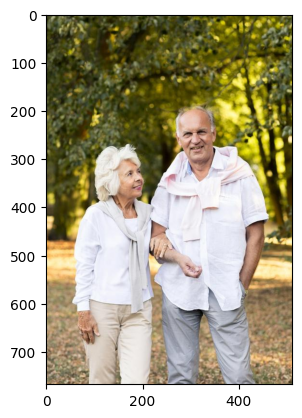

In [6]:
img = plt.imread("train_data/041be3153810433ab146bc97d5af505c.jpg")
plt.imshow(img)

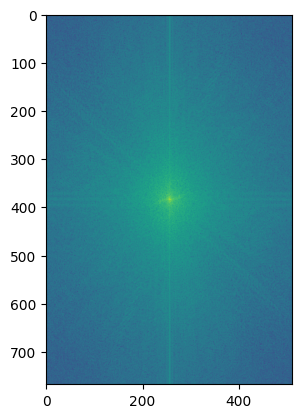

In [7]:
def dft_magnitude_spectrum(image):
    # Convert image to grayscale if it's not already
    if len(image.shape) > 2:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Compute DFT
    dft = np.fft.fft2(image)
    dft_shift = np.fft.fftshift(dft)

    # Compute magnitude spectrum
    magnitude_spectrum = 20 * np.log(np.abs(dft_shift) + 1)

    return magnitude_spectrum


plt.imshow(dft_magnitude_spectrum(img))

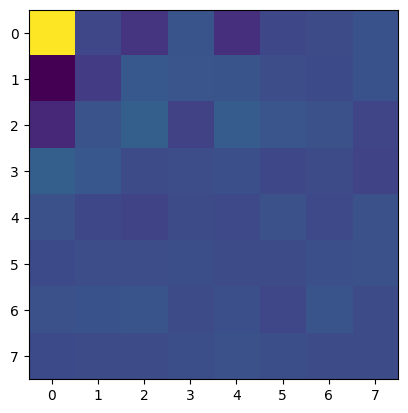

In [8]:
def dct_features(image, block_size=8):
    # Convert image to grayscale if it's not already
    if len(image.shape) > 2:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Compute DCT
    dct = cv2.dct(np.float32(image))

    # Extract features from DCT coefficients
    features = dct[:block_size, :block_size]

    return features


plt.imshow(dct_features(img))

In [9]:
def gabor_features(image, num_filters=8):
    # Convert image to grayscale if it's not already
    if len(image.shape) > 2:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    features = []
    for theta in np.arange(0, np.pi, np.pi / num_filters):
        kernel = cv2.getGaborKernel((21, 21), 5, theta, 10, 0.5, 0, ktype=cv2.CV_32F)
        filtered = cv2.filter2D(image, cv2.CV_8UC3, kernel)
        features.extend([np.mean(filtered), np.std(filtered)])

    return np.array(features)


gabor_features(img).shape

(16,)

In [10]:
def multi_level_dwt(image, levels=1):
    """
    Perform multi-level 2D Discrete Wavelet Transform using Haar filters.

    :param image: Input 2D array (grayscale image)
    :param levels: Number of decomposition levels
    :return: List of tuples, each containing (LL, LH, HL, HH) for each level
    """
    # Ensure the image is float32
    image = image.astype(np.float32)

    # Haar wavelet filters
    low_filter = np.array([1, 1]) / np.sqrt(2)
    high_filter = np.array([1, -1]) / np.sqrt(2)

    def dwt2(img):
        # Convolution and downsampling along rows
        low_rows = cv2.filter2D(img, -1, low_filter[np.newaxis, :])[:, ::2]
        high_rows = cv2.filter2D(img, -1, high_filter[np.newaxis, :])[:, ::2]

        # Convolution and downsampling along columns
        LL = cv2.filter2D(low_rows, -1, low_filter[:, np.newaxis])[::2, :]
        LH = cv2.filter2D(low_rows, -1, high_filter[:, np.newaxis])[::2, :]
        HL = cv2.filter2D(high_rows, -1, low_filter[:, np.newaxis])[::2, :]
        HH = cv2.filter2D(high_rows, -1, high_filter[:, np.newaxis])[::2, :]

        return LL, LH, HL, HH

    features = []
    approximation = image

    for _ in range(levels):
        LL, LH, HL, HH = dwt2(approximation)
        features.append((LL, LH, HL, HH))
        approximation = LL

    return features


# Example usage
# if __name__ == "__main__":
# Load a grayscale image
# image = cv2.imread("example.png", cv2.IMREAD_GRAYSCALE)

# Perform 3-level DWT
dwt_features = multi_level_dwt(img, levels=3)

# Print shapes of features at each level
for level, (LL, LH, HL, HH) in enumerate(dwt_features, 1):
    print(f"Level {level}:")
    print(f"  LL shape: {LL.shape}")
    print(f"  LH shape: {LH.shape}")
    print(f"  HL shape: {HL.shape}")
    print(f"  HH shape: {HH.shape}")
    print()

Level 1:
  LL shape: (384, 256, 3)
  LH shape: (384, 256, 3)
  HL shape: (384, 256, 3)
  HH shape: (384, 256, 3)

Level 2:
  LL shape: (192, 128, 3)
  LH shape: (192, 128, 3)
  HL shape: (192, 128, 3)
  HH shape: (192, 128, 3)

Level 3:
  LL shape: (96, 64, 3)
  LH shape: (96, 64, 3)
  HL shape: (96, 64, 3)
  HH shape: (96, 64, 3)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


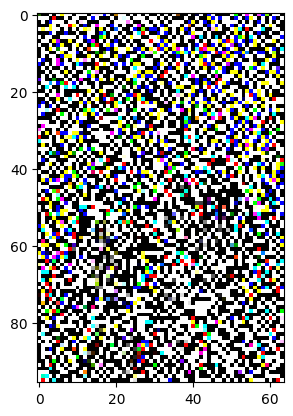

In [11]:
plt.imshow(
    # dwt_features[0][0] +
    # dwt_features[0][1] +
    # dwt_features[0][2] +
    dwt_features[2][3]
)

In [12]:
def make_image_array(image_paths_array):
    all_images = []
    for image_paths in image_paths_array:
        all_images.append([])
        for image_name in image_paths:
            image = plt.imread(image_name)
            # dwt_features = multi_level_dwt(image, levels=1)
            # image = dwt_features[0][1]
            # image = dft_magnitude_spectrum(image=image)
            all_images[-1].append(image)
    return all_images


def display_images(image_array):
    """
    Displays a 2D array of images in a grid layout using Matplotlib.

    Parameters:
        image_array (list of lists or numpy.ndarray): A 2D array where each row contains 'n' images,
                                                        and there are 'k' rows.
    """
    # Determine the number of rows (k) and columns (n)
    k = len(image_array)
    n = len(image_array[0]) if k > 0 else 0

    # Create a figure with subplots
    fig, axes = plt.subplots(
        k, n, figsize=(n * 3, k * 3)
    )  # Adjust figsize for better visualization

    # Flatten axes for easier iteration (handles both single-row and multi-row cases)
    axes = axes.ravel() if k > 1 else [axes]

    # Iterate through the 2D image array and plot each image
    for i, row in enumerate(image_array):
        for j, img in enumerate(row):
            index = i * n + j
            axes[index].imshow(
                img, cmap="gray"
            )  # Assuming grayscale images; adjust cmap as needed
            axes[index].axis("off")  # Turn off axis for cleaner visualization

    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show()

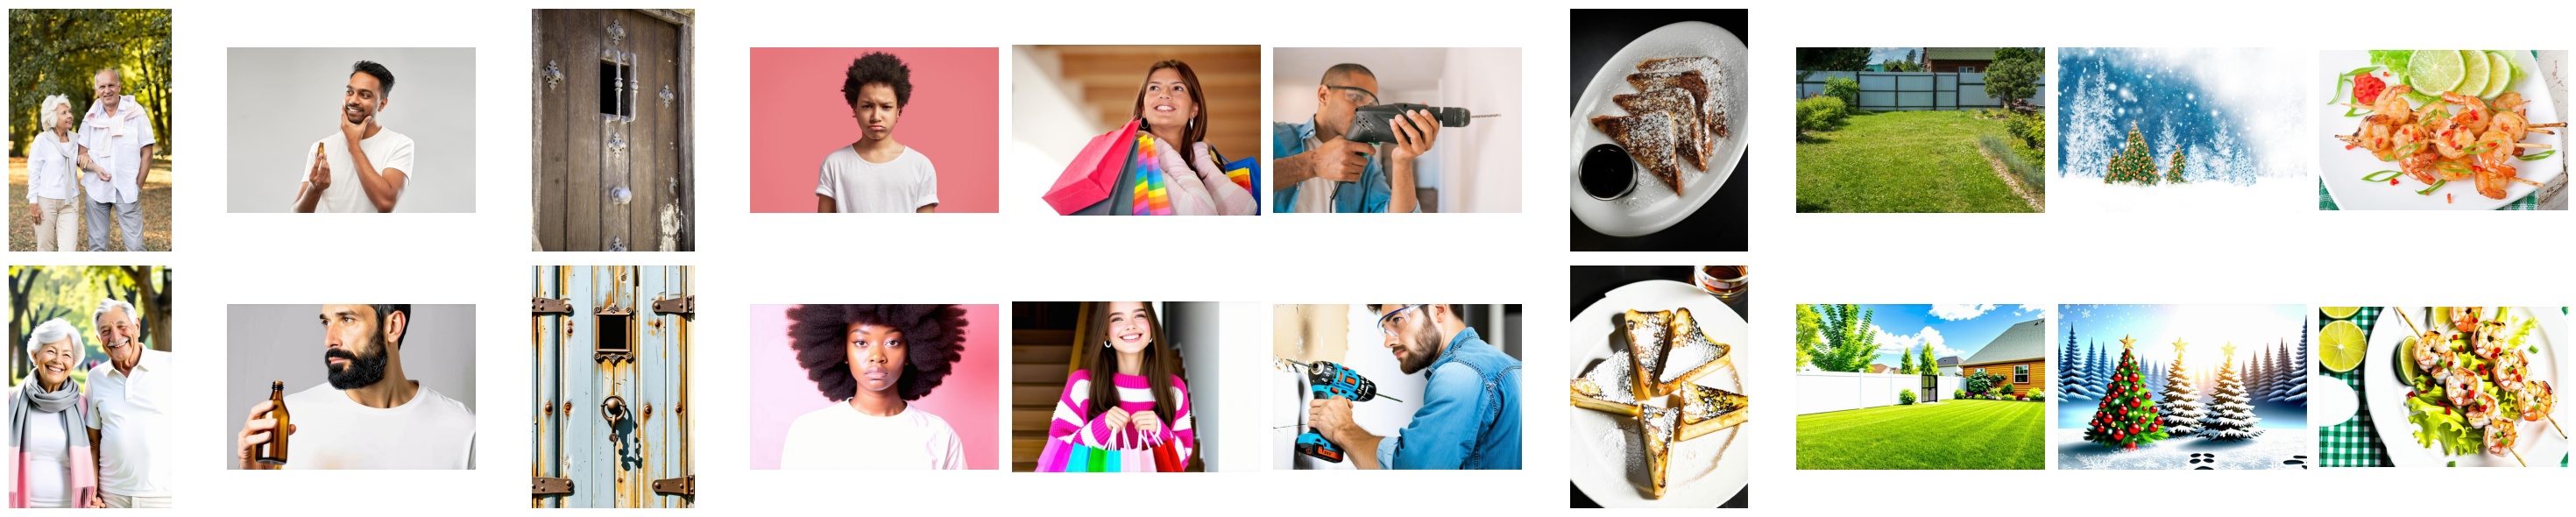

In [13]:
def compare_samples(num_samples):
    normal_image_names = get_n_samples_of(df, "file_name", 0, "label", num_samples)
    generated_image_names = get_n_samples_of(df, "file_name", 1, "label", num_samples)

    display_images(make_image_array([normal_image_names, generated_image_names]))


compare_samples(10)

In [26]:
def compute_hfi_score_dft(image):
    """
    Computes the High-Frequency Influence (HFI) score using DFT for an input image.

    Parameters:
        image (numpy.ndarray): Input image (grayscale or color).

    Returns:
        float: HFI score representing the influence of high-frequency components.
    """
    # Step 1: Convert the image to grayscale if it's in color
    if len(image.shape) == 3:
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray_image = image

    # Step 2: Apply Discrete Fourier Transform (DFT) to analyze frequency components
    dft = cv2.dft(np.float32(gray_image), flags=cv2.DFT_COMPLEX_OUTPUT)
    dft_shift = np.fft.fftshift(dft)

    # Step 3: Compute the magnitude spectrum
    magnitude_spectrum = cv2.magnitude(dft_shift[:, :, 0], dft_shift[:, :, 1])

    # Step 4: Create a mask to separate low and high frequencies
    rows, cols = gray_image.shape
    crow, ccol = rows // 2, cols // 2  # Center of the frequency spectrum
    radius = min(rows, cols) // 8  # Radius for low-frequency region

    # Low-frequency mask: Circular region at the center
    low_freq_mask = np.zeros((rows, cols), np.uint8)
    cv2.circle(low_freq_mask, (ccol, crow), radius, 1, thickness=-1)

    # High-frequency mask: Everything outside the low-frequency region
    high_freq_mask = 1 - low_freq_mask

    # Step 5: Calculate energy in low and high frequencies
    low_freq_energy = np.sum(magnitude_spectrum * low_freq_mask)
    high_freq_energy = np.sum(magnitude_spectrum * high_freq_mask)

    # Step 6: Compute the HFI score as the ratio of high-frequency energy to total energy
    total_energy = low_freq_energy + high_freq_energy
    hfi_score = high_freq_energy / total_energy if total_energy != 0 else 0

    return hfi_score


def compute_hfi_score_dct(image):
    """
    Computes the High-Frequency Influence (HFI) score using DCT for an input image.

    Parameters:
        image (numpy.ndarray): Input image (grayscale or color).

    Returns:
        float: HFI score representing the influence of high-frequency components.
    """
    # Step 1: Convert the image to grayscale if it's in color
    if len(image.shape) == 3:
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray_image = image

    # Step 2: Apply Discrete Cosine Transform (DCT)
    dct_transform = cv2.dct(np.float32(gray_image))

    # Step 3: Separate low and high frequencies using a mask
    rows, cols = gray_image.shape
    crow, ccol = rows // 2, cols // 2

    # Low-frequency mask: Top-left corner of DCT coefficients matrix
    radius_x, radius_y = rows // 8, cols // 8
    low_freq_mask = np.zeros((rows, cols), np.uint8)
    low_freq_mask[:radius_x, :radius_y] = 1

    # High-frequency mask: Everything outside the top-left corner
    high_freq_mask = 1 - low_freq_mask

    # Step 4: Calculate energy in low and high frequencies
    low_freq_energy = np.sum(dct_transform * low_freq_mask)
    high_freq_energy = np.sum(dct_transform * high_freq_mask)

    # Step 5: Compute the HFI score as the ratio of high-frequency energy to total energy
    total_energy = low_freq_energy + high_freq_energy
    hfi_score = high_freq_energy / total_energy if total_energy != 0 else 0

    return hfi_score


def compute_hfi_score_gabor(
    image,
    frequencies=[0.1, 0.3],
    orientations=[
        0,
        np.pi / 6,
        np.pi / 3,
        np.pi / 2,
        2 * np.pi / 3,
        5 * np.pi / 6,
        np.pi
    ],
):
    """
    Computes the High-Frequency Influence (HFI) score using Gabor filters with OpenCV and NumPy.

    Parameters:
        image (numpy.ndarray): Input image (grayscale or color).
        frequencies (list): List of frequencies for the Gabor filters.
        orientations (list): List of orientations (angles in radians) for the Gabor filters.

    Returns:
        float: HFI score representing the influence of high-frequency components.
    """
    # Step 1: Convert the image to grayscale if it's in color
    if len(image.shape) == 3:
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray_image = image

    # Normalize the image for better filter responses
    gray_image = (gray_image - gray_image.mean()) / gray_image.std()

    # Initialize variables to track energy in low and high frequencies
    low_freq_energy = 0
    high_freq_energy = 0

    # Step 2: Create and apply Gabor filters for each frequency and orientation
    for frequency in frequencies:
        wavelength = 1 / frequency  # Wavelength is the inverse of frequency
        for theta in orientations:
            # Create a Gabor kernel using OpenCV
            kernel = cv2.getGaborKernel(
                ksize=(31, 31),  # Kernel size (can be adjusted)
                sigma=4.0,  # Standard deviation of Gaussian envelope
                theta=theta,  # Orientation of the filter in radians
                lambd=wavelength,  # Wavelength of sinusoidal component
                gamma=0.5,  # Spatial aspect ratio
                psi=0,  # Phase offset
            )

            # Convolve the image with the Gabor kernel
            filtered_image = cv2.filter2D(gray_image, cv2.CV_64F, kernel)

            # Compute the energy of the filtered response
            energy = np.sum(filtered_image**2)

            # Classify energy into low or high frequency based on frequency value
            if frequency < 0.15:  # Threshold for low-frequency components
                low_freq_energy += energy
            else:
                high_freq_energy += energy

    # Step 3: Compute the HFI score as the ratio of high-frequency energy to total energy
    total_energy = low_freq_energy + high_freq_energy
    hfi_score = high_freq_energy / total_energy if total_energy != 0 else 0

    return hfi_score

In [32]:
normal_image_names = get_n_samples_of(df, "file_name", 0, "label", 1000)
generated_image_names = get_n_samples_of(df, "file_name", 1, "label", 1000)

image_array = make_image_array([normal_image_names, generated_image_names])

In [40]:
scores = []
for i, image_set in enumerate(image_array):
    scores.append([])
    for image in image_set:
        # hfi = compute_hfi_score_dft(image)
        # scores[-1].append(hfi)
        hfi = compute_hfi_score_dct(image)
        scores[-1].append(hfi)
        # hfi = compute_hfi_score_gabor(image)
        # scores[-1].append(hfi)

scores = np.array(scores)
scores.mean(axis=-1)

array([-0.0056453 ,  0.01719861], dtype=float32)

<Axes: ylabel='Count'>

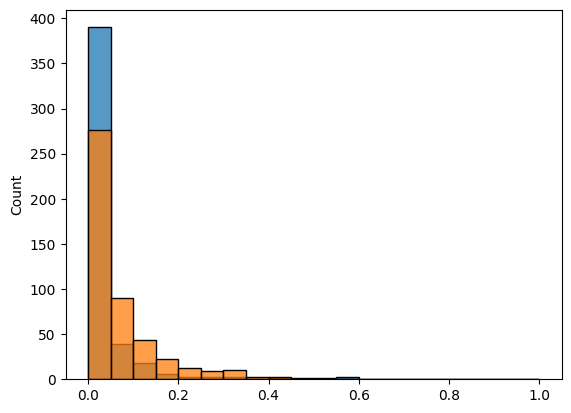

In [42]:
orig_scores, ai_scores = scores
sns.histplot(orig_scores, bins=20, binrange=[0,1])
sns.histplot(ai_scores, bins=20, binrange=[0, 1])